In [1]:
!pip install torchview
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=7bc2a46108a02c66b36b1f52ebf9d9ec52c1984d7ee3f7d2ce66da444c2f44cc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")

In [3]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

def load_image(path):
    with Image.open(path) as f:
        img_array = np.array(f).reshape((125, 125, 8))
    return img_array

def load_images_from_directory(directory):
    paths = [os.path.join(directory, file) for file in os.listdir(directory)][:30000]
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, paths), total=len(paths)))
    return images

# Load images from both directories
X_one = load_images_from_directory('/kaggle/input/gsocfiltered/dataset/one/')
X_two = load_images_from_directory('/kaggle/input/gsocfiltered/dataset/two/')

# Combine datasets
X = X_one + X_two

100%|██████████| 30000/30000 [00:19<00:00, 1507.96it/s]


In [4]:
X_train = X[:54000]
X_test = X[54000:60000]
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape

(54000, 125, 125, 8)

In [5]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


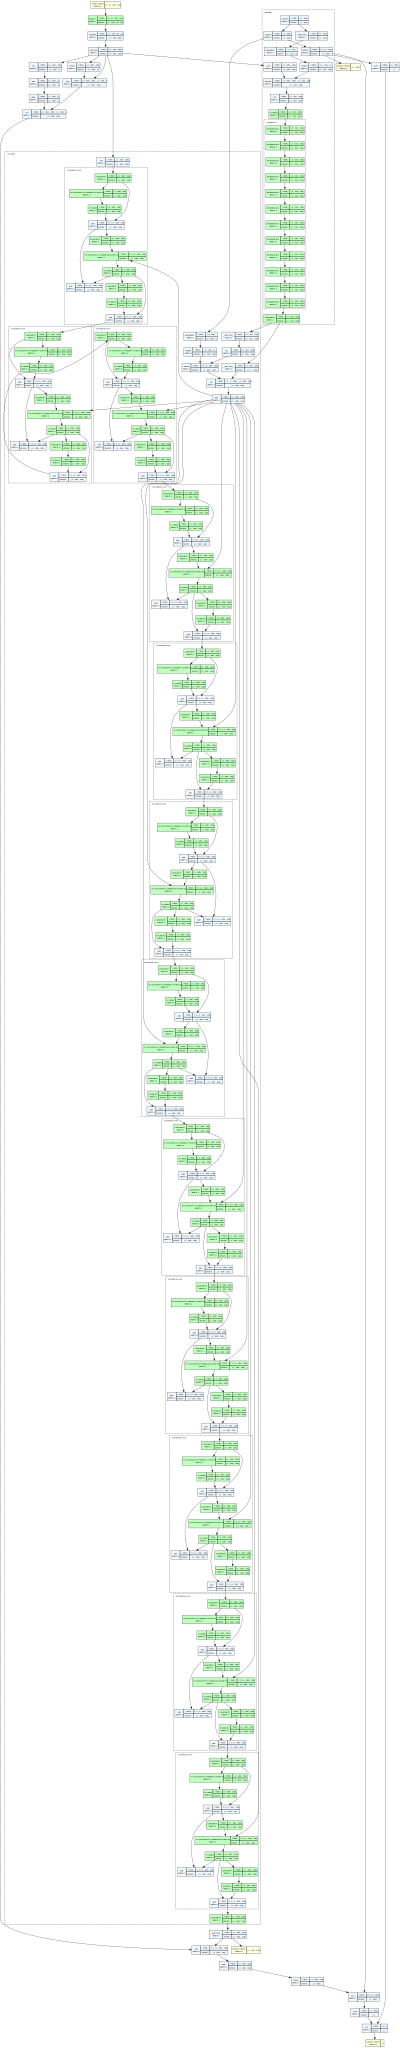

In [6]:
import math
from collections import OrderedDict
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.ops.misc import Conv2dNormActivation, MLP
from torchvision.transforms._presets import ImageClassification, InterpolationMode
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface


class CrissCrossMultiheadSelfAttention(nn.Module):
    def __init__(self, k_factor, num_heads, in_channels):
        super(CrissCrossMultiheadSelfAttention, self).__init__()
        self.k_factor = k_factor
        self.num_heads = num_heads
        self.in_channels = in_channels


        self.qkv_linear = nn.ModuleList()
        for _ in range(in_channels):
            self.qkv_linear.append(nn.Linear(k_factor, k_factor * 3))
        self.fc_out = nn.Linear(k_factor, k_factor)

    def forward(self, x):
        '''
        The following input shape can be achieved by modifying the convolutional layers
        in the ViT preprocessing to be depth-wise with in_channels = K*in_channels and
        groups = in_channels where K is the scale factor of how many convolutional
        filters you want for each image channel
        V,K,Q input shape: batch_size, length, hidden_dim*channels
        '''
        N = x.shape[0]

        #channels shape: [[batch_size, length, hidden_dim], ...] list length=in_channels
        in_channels = x.chunk(self.in_channels, dim=2)

        queries = []
        keys = []
        values = []
        for channel, qkv in zip(in_channels, self.qkv_linear):
            q, k, v = qkv(channel).chunk(3, dim=-1)
            queries.append(q)
            keys.append(k)
            values.append(v)

        #q, k before: [[batch_size, length, hidden_dim], ...] list length=in_channels
        queries = torch.stack(queries, -1).unsqueeze(-1)
        keys = torch.stack(keys, -1).unsqueeze(-2)
        values = torch.stack(values, -1)
        #q shape after: (batch_size, length, hidden_dim, in_channels, 1)
        #k shape after: (batch_size, length, hidden_dim, 1, in_channels)

        #scores shape: (batch_size, length, hidden_dim, in_channels, in_channels)
        scores = torch.matmul(queries, keys) / (self.k_factor ** 0.5)
        attention = F.softmax(scores, -1)

        #context shape: (batch_size, length, hidden_dim, in_channels)
        context = torch.einsum('ijklm,ijkl->ijkm', attention, values)

        #context shape: (batch_size, length, in_channels, hidden_dim)
        context = context.transpose(-2, -1)

        out = self.fc_out(context)

        #out shape: (batch_size, length, in_channels * hidden_dim)
        out = out.flatten(start_dim=2)

        return out

class CrissCrossMultiheadCrossAttention(nn.Module):
    def __init__(self, k_factor, num_heads, in_channels):
        super(CrissCrossMultiheadCrossAttention, self).__init__()
        self.k_factor = k_factor
        self.num_heads = num_heads
        self.in_channels = in_channels


        self.q_linear = nn.ModuleList()
        self.kv_linear = nn.ModuleList()
        for _ in range(in_channels):
            self.q_linear.append(nn.Linear(k_factor, k_factor))
            self.kv_linear.append(nn.Linear(k_factor, k_factor * 2))
        self.fc_out = nn.Linear(k_factor, k_factor)

    def forward(self, x, context):
        '''
        The following input shape can be achieved by modifying the convolutional layers
        in the ViT preprocessing to be depth-wise with in_channels = K*in_channels and
        groups = in_channels where K is the scale factor of how many convolutional
        filters you want for each image channel
        V,K,Q input shape: batch_size, length, hidden_dim*channels
        '''
        N = x.shape[0]

        #channels shape: [[batch_size, length, hidden_dim], ...] list length=in_channels
        in_channels = x.chunk(self.in_channels, dim=2)

        context_in_channels = context.chunk(self.in_channels, dim=2)

        queries = []
        keys = []
        values = []
        for channel, cont_channel, q_lin, kv_lin in zip(in_channels, context_in_channels, self.q_linear, self.kv_linear):
            q = q_lin(channel)
            k, v = kv_lin(cont_channel).chunk(2, dim=-1)
            queries.append(q)
            keys.append(k)
            values.append(v)

        #q, k before: [[batch_size, length, hidden_dim], ...] list length=in_channels
        queries = torch.stack(queries, -1).unsqueeze(-1)
        keys = torch.stack(keys, -1).unsqueeze(-2)
        values = torch.stack(values, -1)
        #q shape after: (batch_size, length, hidden_dim, in_channels, 1)
        #k shape after: (batch_size, length, hidden_dim, 1, in_channels)

        #scores shape: (batch_size, length, hidden_dim, in_channels, in_channels)
        scores = torch.matmul(queries, keys) / (self.k_factor ** 0.5)
        attention = F.softmax(scores, -1)

        #context shape: (batch_size, length, hidden_dim, in_channels)
        context = torch.einsum('ijklm,ijkl->ijkm', attention, values)

        #context shape: (batch_size, length, in_channels, hidden_dim)
        context = context.transpose(-2, -1)

        out = self.fc_out(context)

        #out shape: (batch_size, length, in_channels * hidden_dim)
        out = out.flatten(start_dim=2)

        return out


class ConvStemConfig(NamedTuple):
    out_channels: int
    kernel_size: int
    stride: int
    norm_layer: Callable[..., nn.Module] = nn.BatchNorm2d
    activation_layer: Callable[..., nn.Module] = nn.ReLU


class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )


class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        in_channels: int,
        k_factor: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = CrissCrossMultiheadSelfAttention(k_factor, num_heads, in_channels)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x = self.self_attention(x)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_channels: int,
        k_factor: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.enc_pos_embedding = nn.Parameter(torch.empty(1, seq_length + 1, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                num_channels,
                k_factor,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))


    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward(self, input: torch.Tensor, mask_ratio=0.5):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = input + self.enc_pos_embedding[:, 1:, :]
        input, mask, ids_restore = self.random_masking(input, mask_ratio)
        cls_token = self.cls_token + self.enc_pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(input.shape[0], -1, -1)
        input = torch.cat((cls_tokens, input), dim=1)
        return self.ln(self.layers(self.dropout(input))), mask, ids_restore


class DecoderBlock(nn.Module):
    """Transformer decoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        in_channels: int,
        k_factor: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = CrissCrossMultiheadSelfAttention(k_factor, num_heads, in_channels)
        self.ln_2 = norm_layer(hidden_dim)
        self.cross_attention = CrissCrossMultiheadCrossAttention(k_factor, num_heads, in_channels)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_3 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor, context: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = self.ln_1(input)
        x = self.self_attention(input)
        input = input + self.dropout(x)
        x = self.ln_2(input)
        x = self.cross_attention(x, context)
        input = input + self.dropout(x)

        y = self.ln_3(x)
        y = self.mlp(y)
        return x + y


class Decoder(nn.Module):
    """Transformer Model Decoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_channels: int,
        k_factor: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.dec_pos_embedding = nn.Parameter(torch.empty(1, seq_length + 1, hidden_dim).normal_(std=0.02))  # from BERT
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = DecoderBlock(
                num_heads,
                hidden_dim,
                num_channels,
                k_factor,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

    def forward(self, x: torch.Tensor, context: torch.Tensor, ids_restore: torch.Tensor):
        torch._assert(x.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {x.shape}")
        cls_token = self.cls_token + self.dec_pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        mask_tokens = self.mask_token.repeat(context.shape[0], ids_restore.shape[1] + 1 - context.shape[1], 1)
        context_ = torch.cat([context[:, 1:, :], mask_tokens], dim=1)  # no cls token
        context_ = torch.gather(context_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, context.shape[2]))  # unshuffle
        context = torch.cat([context[:, :1, :], context_], dim=1)  # append cls token
        context = context + self.dec_pos_embedding

        for l in self.layers:
            x = l(x, context)
        return self.ln(x)



class DepthwiseCrossViTMAE(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int,
        in_channels: int,
        k_factor: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
        num_classes: int = 1,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        mask_ratio: float = 0.5,
    ):
        super().__init__()
        _log_api_usage_once(self)
        torch._assert(image_size % patch_size == 0, "Input shape indivisible by patch size!")
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.k_factor = k_factor
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.norm_layer = norm_layer
        self.mask_ratio = mask_ratio

        self.conv_proj = nn.Conv2d(
            in_channels=in_channels, groups=in_channels, out_channels=in_channels*k_factor, kernel_size=patch_size, stride=patch_size
        )

        seq_length = (image_size // patch_size) ** 2

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

        self.encoder = Encoder(
            seq_length,
            num_layers,
            in_channels,
            k_factor,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )

        self.decoder = Decoder(
            seq_length,
            num_layers,
            in_channels,
            k_factor,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )

        self.seq_length = seq_length

        if isinstance(self.conv_proj, nn.Conv2d):
            # Init the patchify stem
            fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
            nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
            if self.conv_proj.bias is not None:
                nn.init.zeros_(self.conv_proj.bias)
        elif self.conv_proj.conv_last is not None and isinstance(self.conv_proj.conv_last, nn.Conv2d):
            # Init the last 1x1 conv of the conv stem
            nn.init.normal_(
                self.conv_proj.conv_last.weight, mean=0.0, std=math.sqrt(2.0 / self.conv_proj.conv_last.out_channels)
            )
            if self.conv_proj.conv_last.bias is not None:
                nn.init.zeros_(self.conv_proj.conv_last.bias)


    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!")
        torch._assert(w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, in_channels * k_factor, n_h, n_w) -> (n, in_channels * k_factor, (n_h * n_w))
        x = x.reshape(n, self.in_channels * self.k_factor, n_h * n_w)

        # (n, in_channels * k_factor, (n_h * n_w)) -> (n, (n_h * n_w), in_channels * k_factor)
        # The self attention layer expects inputs in the format (N, L, D)
        # where L is the source sequence length, N is the batch size, D is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

    def forward_loss(self, target, pred, mask):
        """
        imgs: [N, C, H, W]
        pred: [N, L, p*p*C]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)
        target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch


        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs: torch.Tensor):
        # Reshape and permute the input tensor
        imgs = self._process_input(imgs)
        n = imgs.shape[0]

        enc_output, mask, ids_restore = self.encoder(imgs, self.mask_ratio)
        x = self.decoder(imgs, enc_output, ids_restore)

        # Remove the class token
        x = x[:, 1:, :]

        loss = self.forward_loss(imgs, x, mask)
        return loss, x, mask


def _vision_transformer(
    patch_size: int,
    in_channels: int,
    k_factor: int,
    num_layers: int,
    num_heads: int,
    hidden_dim: int,
    mlp_dim: int,
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> DepthwiseCrossViTMAE:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))
        assert weights.meta["min_size"][0] == weights.meta["min_size"][1]
        _ovewrite_named_param(kwargs, "image_size", weights.meta["min_size"][0])
    image_size = kwargs.pop("image_size", 125)

    model = DepthwiseCrossViTMAE(
        image_size=image_size,
        in_channels=in_channels,
        k_factor=k_factor,
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        **kwargs,
    )

    if weights:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model

model = _vision_transformer(
                            patch_size=5,
                            in_channels=8,
                            k_factor=16,
                            num_layers=12,
                            num_heads=4,
                            hidden_dim=128,
                            mlp_dim=64,
                            weights=None,
                            progress=False,
                            )

import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [7]:
x = torch.rand((1,8,125,125)).to('cuda')
loss, outputs, mask = model(x)
# len(mask[0])
loss

tensor(2.0520, device='cuda:0', grad_fn=<DivBackward0>)

In [8]:
import torchvision
# from torchview import draw_graph
# model_graph = draw_graph(model, input_size=(16,8,125,125), expand_nested=True)
# model_graph.visual_graph      

In [9]:
# def binary_cross_entropy_manual(y_pred, y_true, mask):
#     def sigmoid(x):
#         return 1 / (1 + torch.exp(-x))

#     N = y_pred.shape[0]  
#     y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], 8, y_true.shape[2]//8))
#     y_pred = y_pred.reshape((y_pred.shape[0], y_pred.shape[1], 8, y_pred.shape[2]//8))
#     total_loss = 0
    
#     for i in range(len(mask)):
#         loss = y_true[:,:,i,:] * torch.log(y_pred[:,:,i,:]) + (1 - y_true[:,:,i,:]) * torch.log(1 - y_pred[:,:,i,:])
#         mask_cpu = mask[i].unsqueeze(-1)
#         masked_loss = torch.sum(loss * mask_cpu) / (mask_cpu.sum())
#         total_loss += (masked_loss)*(-1)
        
#     return total_loss/N

# loss = binary_cross_entropy_manual(x, imgs, mask)
# print(loss)


In [10]:
X_train[0].max()

255

In [11]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, transform):
        self.x = x
#         self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = (self.x[idx]).astype('float32')/255.0
        
        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1}
        
        return sample
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = Custom_Dataset(X_train, transform = transform)
test_dataset = Custom_Dataset(X_test, transform = transform)

sample = train_dataset.__getitem__(0)
print((sample['img']).max())

tensor(1.)


In [12]:
# import numpy as np
# import torch

# def custom_loss(imgs, pred, mask):
#     imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2]//8))
#     pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2]//8))


#     L = 0
#     for i in range(len(mask)):
#         l = ((pred[:, : ,i, :] - imgs[:, : ,i, :])**2).unsqueeze(axis = 2).mean(axis = -1)
#         # Move the mask tensor to the CPU before converting it to a NumPy array
#         mask_cpu = mask[i].unsqueeze(axis = -1)
#         loss = (l * mask_cpu).sum()
#         L+=((loss / mask_cpu.sum()))
    
#     return L/8

In [13]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy

# Define your Custom_Dataset class here (assuming it's defined earlier)

# Define your MaskedAutoencoderViT class here (assuming it's defined earlier)

def model_train(model, epochs, train_dataloader, val_dataloader, device):
#     criterion = custom_loss()
    optimizer = AdamW(model.parameters(), lr=1.5e-4, weight_decay=0.05)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        model.train()
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            images = batch['img'].to(device).float()

            optimizer.zero_grad()
            loss, outputs, mask = model(images)
            loss.mean().backward()
            optimizer.step()

            train_loss += loss.mean().item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        original_image = None
        reconstructed_image = None
        
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Val)', unit='batch'):
                images = batch['img'].to(device).float()
                original_image = images
                loss, outputs, mask = model(images)
                val_loss += loss.mean().item()

        val_loss /= len(val_dataloader)
        val_losses.append(loss)

        scheduler.step()
        
#         channel_wise_visualization(original_image[0], reconstructed_image[0])

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        with open('losses.txt', 'a') as f:  # Open file in append mode
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}\n')
    
        torch.save(model.module.state_dict(), f'./best_model.pth')
    
    return train_losses, val_losses

# Assuming dataset, train_dataloader, and val_dataloader are defined earlier

# Define your model
# del model
gc.collect()
torch.cuda.empty_cache()

In [14]:
del model
gc.collect()
torch.cuda.empty_cache()

In [15]:
model = _vision_transformer(
                            patch_size=5,
                            in_channels=8,
                            k_factor=16,
                            num_layers=12,
                            num_heads=4,
                            hidden_dim=128,
                            mlp_dim=64,
                            weights=None,
                            progress=False,
                            )

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

DEVICE = torch.torch.device("cuda")
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    model = nn.DataParallel(model)
model = model.to(DEVICE)

train_losses, val_losses = model_train(model, 60, train_dataloader, val_dataloader, DEVICE)

Epoch 1/60 (Train):   0%|          | 0/422 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Epoch 1/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 1/60, Train Loss: 0.25729421862529067, Val Loss: 0.05764932018962312


Epoch 2/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 2/60, Train Loss: 0.027360572353870523, Val Loss: 0.011728703460477769


Epoch 3/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 3/60, Train Loss: 0.005865117205611443, Val Loss: 0.002668661560783995


Epoch 4/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 4/60, Train Loss: 0.0013297667839427554, Val Loss: 0.0005874655189666342


Epoch 5/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 5/60, Train Loss: 0.0002826231424418119, Val Loss: 0.00011439221394694153


Epoch 6/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 6/60, Train Loss: 5.191809301081409e-05, Val Loss: 1.8423279664390028e-05


Epoch 7/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 7/60, Train Loss: 7.831776620430952e-06, Val Loss: 2.3871351420390793e-06


Epoch 8/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 8/60, Train Loss: 1.1870004046049094e-06, Val Loss: 3.2964743286840453e-07


Epoch 9/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 9/60, Train Loss: 5.334457292871099e-07, Val Loss: 5.777263520533953e-07


Epoch 10/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 10/60, Train Loss: 4.4683312638796443e-07, Val Loss: 8.254009530707876e-08


Epoch 11/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 11/60, Train Loss: 4.098379299713843e-07, Val Loss: 5.5185733694369e-08


Epoch 12/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 12/60, Train Loss: 4.339222064676407e-07, Val Loss: 4.93767232302268e-08


Epoch 13/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 13/60, Train Loss: 3.541558627278723e-07, Val Loss: 1.655668742909682e-07


Epoch 14/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 14/60, Train Loss: 3.647081809045834e-07, Val Loss: 7.449743970647296e-08


Epoch 15/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 15/60, Train Loss: 3.3707579468023844e-07, Val Loss: 9.62373957357139e-07


Epoch 16/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 16/60, Train Loss: 2.946460834265677e-07, Val Loss: 7.091705658646613e-08


Epoch 17/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 17/60, Train Loss: 2.4005786302028154e-07, Val Loss: 1.1668742595150995e-06


Epoch 18/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 18/60, Train Loss: 2.3565282125869806e-07, Val Loss: 1.509329527554191e-08


Epoch 19/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 19/60, Train Loss: 2.0504979149698044e-07, Val Loss: 1.5227085370383975e-08


Epoch 20/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 20/60, Train Loss: 1.7276582588766573e-07, Val Loss: 1.408969239341883e-07


Epoch 21/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 21/60, Train Loss: 1.3804048185717753e-07, Val Loss: 5.184074801585415e-08


Epoch 22/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 22/60, Train Loss: 1.0178834927538873e-07, Val Loss: 1.2706369184246447e-07


Epoch 23/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 23/60, Train Loss: 1.0248194174899656e-07, Val Loss: 2.8810952640172103e-08


Epoch 24/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 24/60, Train Loss: 6.509718991973897e-08, Val Loss: 1.193586807074369e-07


Epoch 25/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 25/60, Train Loss: 6.331378950976727e-08, Val Loss: 2.1502888547756134e-08


Epoch 26/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 26/60, Train Loss: 3.972365165399558e-08, Val Loss: 1.448266207480048e-07


Epoch 27/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 27/60, Train Loss: 4.1330163428579814e-08, Val Loss: 1.5537030763611973e-08


Epoch 28/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 28/60, Train Loss: 2.349027020502439e-08, Val Loss: 2.055613442112335e-08


Epoch 29/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 29/60, Train Loss: 1.4287698959703048e-08, Val Loss: 4.2273385170627545e-08


Epoch 30/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 30/60, Train Loss: 1.3987475541170878e-08, Val Loss: 6.432075467988311e-09


Epoch 31/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 31/60, Train Loss: 9.272420136605212e-09, Val Loss: 1.2249167732135148e-08


Epoch 32/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 32/60, Train Loss: 5.8156028271124614e-09, Val Loss: 5.648831851451729e-09


Epoch 33/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 33/60, Train Loss: 5.5714041479303954e-09, Val Loss: 5.5093030657632605e-09


Epoch 34/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 34/60, Train Loss: 5.451078838445959e-09, Val Loss: 5.399045248702442e-09


Epoch 35/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 35/60, Train Loss: 5.354041300883003e-09, Val Loss: 5.313734161902364e-09


Epoch 36/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 36/60, Train Loss: 5.278044163916156e-09, Val Loss: 5.248370995486355e-09


Epoch 37/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.42batch/s]


Epoch 37/60, Train Loss: 5.223731743109984e-09, Val Loss: 5.205500749126413e-09


Epoch 38/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 38/60, Train Loss: 5.188298333349172e-09, Val Loss: 5.180166140011342e-09


Epoch 39/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.41batch/s]


Epoch 39/60, Train Loss: 5.169122926431248e-09, Val Loss: 5.163723689773111e-09


Epoch 40/60 (Val): 100%|██████████| 47/47 [00:33<00:00,  1.41batch/s]


Epoch 40/60, Train Loss: 5.160592361025001e-09, Val Loss: 5.160685562104047e-09


Epoch 41/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 41/60, Train Loss: 9.654289613272662e-05, Val Loss: 7.595642734167029e-09


Epoch 42/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 42/60, Train Loss: 6.774041532027493e-09, Val Loss: 6.0590583897697175e-09


Epoch 43/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 43/60, Train Loss: 5.509000992091257e-09, Val Loss: 5.0223912026883635e-09


Epoch 44/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 44/60, Train Loss: 4.608378064618259e-09, Val Loss: 4.258159205853475e-09


Epoch 45/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 45/60, Train Loss: 3.980321760971532e-09, Val Loss: 3.7208904704422647e-09


Epoch 46/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 46/60, Train Loss: 3.881427139253874e-08, Val Loss: 3.321867249358008e-09


Epoch 47/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 47/60, Train Loss: 1.2840073691440267e-07, Val Loss: 7.919068151111671e-07


Epoch 48/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 48/60, Train Loss: 3.967608041226302e-07, Val Loss: 7.433009494903634e-08


Epoch 49/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 49/60, Train Loss: 4.937351987439472e-07, Val Loss: 3.2467945230719316e-07


Epoch 50/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 50/60, Train Loss: 5.400518074760613e-07, Val Loss: 1.943571017223571e-07


Epoch 51/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 51/60, Train Loss: 6.568376157086367e-07, Val Loss: 2.2618805427981065e-06


Epoch 52/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 52/60, Train Loss: 7.089967593426537e-07, Val Loss: 2.6668193679645982e-06


Epoch 53/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 53/60, Train Loss: 7.258352104284625e-07, Val Loss: 5.1037651948664905e-08


Epoch 54/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 54/60, Train Loss: 6.567000597083444e-07, Val Loss: 7.810753333948943e-08


Epoch 55/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 55/60, Train Loss: 6.836029361325699e-07, Val Loss: 5.915297797497608e-07


Epoch 56/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 56/60, Train Loss: 6.480475145619393e-07, Val Loss: 2.4545065289953043e-08


Epoch 57/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 57/60, Train Loss: 6.352745053250155e-07, Val Loss: 2.8755475201925965e-08


Epoch 58/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.44batch/s]


Epoch 58/60, Train Loss: 5.988930100578393e-07, Val Loss: 1.4059951859978616e-08


Epoch 59/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]


Epoch 59/60, Train Loss: 5.870560975118622e-07, Val Loss: 6.645743736315009e-07


Epoch 60/60 (Val): 100%|██████████| 47/47 [00:32<00:00,  1.43batch/s]

Epoch 60/60, Train Loss: 5.831733777521479e-07, Val Loss: 2.5270455299950626e-07


In [17]:
# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [18]:
# pred, mask, imgs = model(sample['img'].unsqueeze(0).to('cuda'))

# pred.shape

# def unpatchify(x):
#     """
#     x: (N, L, patch_size**2 *3)
#     imgs: (N, 8, H, W)
#     """
#     p = 5
#     h = w = int(x.shape[1]**.5)
#     assert h * w == x.shape[1]
    
#     x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
#     x = torch.einsum('nhwpqc->nchpwq', x)
#     imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
#     return imgs

# # pred = pred.reshape((125,125,8))
# pred = unpatchify(pred)
# pred.shape
# pred = pred.reshape((8, 125, 125))
# pred.shape

# img = pred.permute(1,2,0)
# img = img.cpu().detach().numpy()

# import matplotlib.pyplot as plt
# for i in range(8):
#     plt.imshow(img[:,:,i])
#     plt.show()